In [1]:
import numpy as np
import pandas as pd 
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="dark")
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Dropout,Activation
from sklearn import preprocessing
import cv2
import glob
import os
import warnings as wr

wr.filterwarnings("ignore")
import numpy as np
import pandas as pd 
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="dark")
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Dropout,Activation
from sklearn import preprocessing
import cv2
import glob
import os
import warnings as wr

wr.filterwarnings("ignore")


In [109]:
train_path=r'Train/Train/JPEGImages'
train_annot=r'Train/Train/Annotations'

test_path=r'Test/Test/JPEGImages'
test_annot=r'Test/Test/Annotations'

val_path =r'Val/Val/JPEGImages'
val_annot = r'Val/Val/Annotations'

In [41]:
def creatingInfoData(Annotpath):
    information={'xmin':[],'ymin':[],'xmax':[],'ymax':[],'ymax':[],'name':[]
                ,'label':[]}

    for file in sorted(glob.glob(str(Annotpath+'/*.xml*'))):
        dat=ET.parse(file)
        for element in dat.iter():    

            if 'object'==element.tag:
                for attribute in list(element):
                    if 'name' in attribute.tag:
                        name = attribute.text                 
                        information['label'] += [name]
                        information['name'] +=[file.split('/')[-1][12:-4]]

                    if 'bndbox'==attribute.tag:
                        for dim in list(attribute):
                            if 'xmin'==dim.tag:
                                xmin=int(round(float(dim.text)))
                                information['xmin']+=[xmin]
                            if 'ymin'==dim.tag:
                                ymin=int(round(float(dim.text)))
                                information['ymin']+=[ymin]
                            if 'xmax'==dim.tag:
                                xmax=int(round(float(dim.text)))
                                information['xmax']+=[xmax]
                            if 'ymax'==dim.tag:
                                ymax=int(round(float(dim.text)))
                                information['ymax']+=[ymax]
                     
    return pd.DataFrame(information)

In [42]:
train_info=creatingInfoData(train_annot)
test_info=creatingInfoData(test_annot)

In [107]:
val_info=creatingInfoData(val_annot)

In [43]:
train_info.head()

,xmin,ymin,xmax,ymax,name,label
0,158,44,289,167,image (1),person
1,185,56,287,241,image (10),person
2,2,86,344,374,image (100),person
3,220,95,500,290,image (100),person
4,13,110,213,375,image (101),person


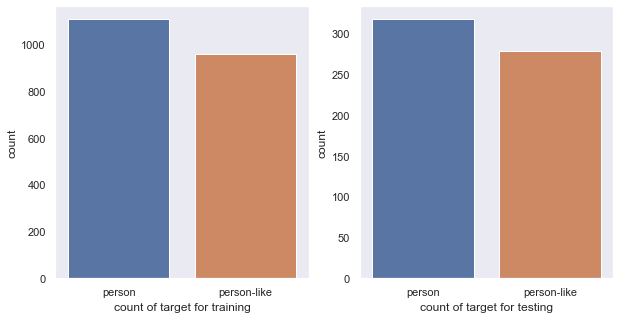

In [44]:
fig=plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.countplot(train_info['label'])
plt.xlabel('count of target for training')

plt.subplot(1,2,2)
sns.countplot(test_info['label'])
plt.xlabel('count of target for testing')

plt.show()

In [45]:
train_info.shape

(2066, 6)

In [47]:
train_info.loc[train_info['name']=='image (101)']

,xmin,ymin,xmax,ymax,name,label
4,13,110,213,375,image (101),person
5,149,127,355,375,image (101),person
6,292,61,500,375,image (101),person


In [56]:
train_info['name'].value_counts()

image (608)    19
image (39)     12
image (909)    12
image (758)    11
image (638)    10
               ..
image (893)     1
image (927)     1
image (314)     1
image (535)     1
image (84)      1
Name: name, Length: 944, dtype: int64

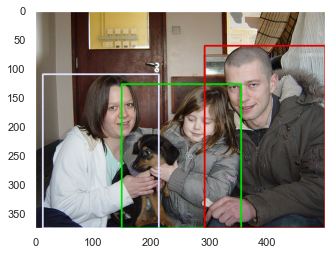

In [59]:
img=cv2.imread(train_path+'/image (101).jpg',cv2.IMREAD_COLOR)

img=cv2.cvtColor(img,cv2.COLOR_BGRA2RGB)

cv2.rectangle(img,(13,110),(213,375),(225,225,255),2)
cv2.rectangle(img,(149,127),(355,375),(0,225,0),2)
cv2.rectangle(img,(292,61),(500,375),(225,0,0),2)

plt.imshow(img)

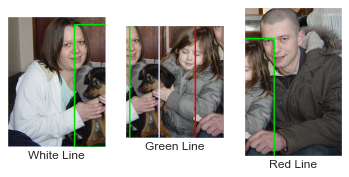

In [60]:
#  y-min, y-max , x-min , x-max
fig=plt.figure()

plt.subplot(1,3,1)
plt.imshow(img[110:375,13:213])
plt.xticks([])
plt.yticks([])
plt.xlabel('White Line')

plt.subplot(1,3,2)
plt.imshow(img[127:375,139:355])
plt.xticks([])
plt.yticks([])
plt.xlabel('Green Line')

plt.subplot(1,3,3)
plt.imshow(img[61:375,292:500])
plt.xticks([])
plt.yticks([])
plt.xlabel('Red Line')

plt.show()

In [61]:
def croppingFromImage(path,Data_information):
    cropped_image=[]
    label=[]
    for i in range(0,len(Data_information)):
        img=cv2.imread(path+'/'+Data_information['name'][i]+'.jpg',cv2.IMREAD_COLOR)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img_=img[Data_information['ymin'][i]:Data_information['ymax'][i],Data_information['xmin'][i]:Data_information['xmax'][i]]
        cropped_image.append(img_)
        
        label.append(Data_information['label'][i])
    return cropped_image , label  

In [62]:
trainImage , trainLabel =croppingFromImage(train_path,train_info)
testImage , testLabel =croppingFromImage(test_path,test_info)

In [63]:
print(len(trainImage) == len(trainLabel))
print(len(testImage) == len(testLabel))

True
True


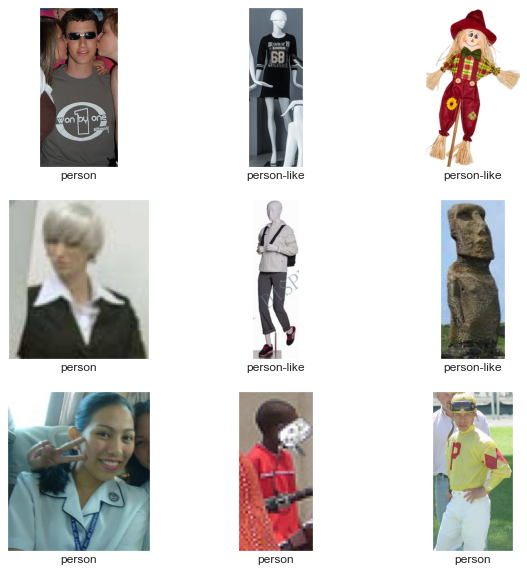

In [64]:
fig=plt.figure(figsize=(10,10))

for i in range (1,10):
    random=np.random.randint(0,len(trainImage))
    plt.subplot(3,3,i)
    plt.imshow(trainImage[random])
    plt.xlabel(trainLabel[random])
    plt.xticks([])
    plt.yticks([])

In [66]:
trainShapes=[]
testShapes=[]
for i in trainImage :
    trainShapes.append(i.shape)
    
for i in testImage :
    testShapes.append(i.shape)

In [67]:
pd.Series(trainShapes).value_counts()[:10]

(374, 499, 3)    4
(101, 55, 3)     2
(179, 47, 3)     2
(101, 32, 3)     2
(358, 271, 3)    2
(221, 197, 3)    2
(44, 34, 3)      2
(273, 218, 3)    2
(101, 49, 3)     2
(163, 105, 3)    2
dtype: int64

In [68]:
def resizing(data,size):
    resizing=[]
    for i in data:
        resizing.append(cv2.resize(i,(size,size)))
        
    return resizing

In [69]:
s=140
X_train,X_test=resizing(trainImage,s),resizing(testImage,s)

In [74]:
X_train[40].shape

(140, 140, 3)

In [75]:
labeling=preprocessing.LabelEncoder()

y_train=labeling.fit_transform(trainLabel)
y_test=labeling.fit_transform(testLabel)

In [82]:
#convert list to array
X_train,X_test=np.asarray(X_train).astype(np.float32),np.asarray(X_test).astype(np.float32)

X_train,X_test=X_train/255.0,X_test/255.0

In [102]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(140, 140, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2))

In [134]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 138, 138, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 69, 69, 16)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 67, 67, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 33, 33, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 31, 31, 64)        18496     
                                                                 
 flatten_2 (Flatten)         (None, 61504)            

In [103]:
import tensorflow as tf

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [104]:
history = model.fit(X_train, y_train, epochs=6, 
                    validation_data=(X_test, y_test))

Epoch 1/6
65/65 [==============================] - 14s 208ms/step - loss: 0.6657 - accuracy: 0.6626 - val_loss: 0.5787 - val_accuracy: 0.7109
Epoch 2/6
65/65 [==============================] - 13s 207ms/step - loss: 0.4558 - accuracy: 0.7991 - val_loss: 0.5035 - val_accuracy: 0.7597
Epoch 3/6
65/65 [==============================] - 14s 210ms/step - loss: 0.3340 - accuracy: 0.8630 - val_loss: 0.4952 - val_accuracy: 0.7916
Epoch 4/6
65/65 [==============================] - 14s 212ms/step - loss: 0.2432 - accuracy: 0.9027 - val_loss: 0.5003 - val_accuracy: 0.8168
Epoch 5/6
65/65 [==============================] - 14s 212ms/step - loss: 0.1552 - accuracy: 0.9429 - val_loss: 0.6021 - val_accuracy: 0.7647
Epoch 6/6
65/65 [==============================] - 14s 213ms/step - loss: 0.0914 - accuracy: 0.9676 - val_loss: 0.7444 - val_accuracy: 0.7765


In [110]:
valImage , valLabel =croppingFromImage(val_path,val_info)

In [130]:
val_label=labeling.fit_transform(valLabel)

In [112]:
s=140
val_images=resizing(valImage,s)

In [118]:

val_arr = np.asarray(val_images).astype(np.float32)

In [119]:
preds = model.predict(val_arr)

11/11 [==============================] - 1s 42ms/step


In [126]:
preds[0]

array([  126.616325, -1010.06396 ], dtype=float32)

In [122]:
class_names = ['person','person-like']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}


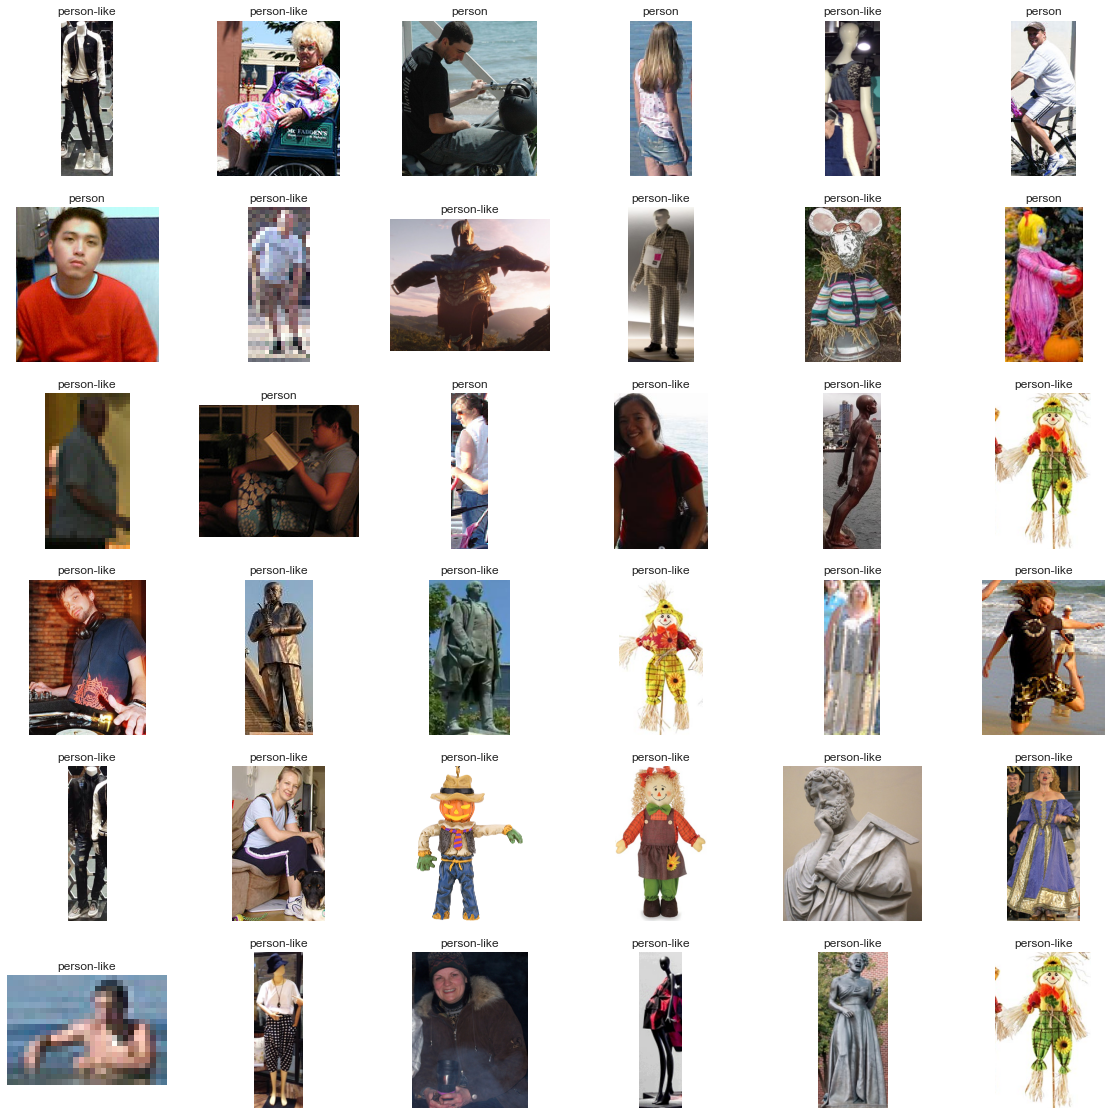

In [124]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(valImage),36))) : 
    plt.subplot(6,6,n+1)
    plt.imshow(valImage[i])    
    plt.axis('off')
    x =np.argmax(preds[i]) # takes the maximum of of the 6 probabilites. 
    plt.title((class_names[x]))

In [127]:
result = []
for i in range(len(preds)):
    result.append(np.argmax(preds[i]))

In [131]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(val_label,result).ravel()

In [132]:
(tn, fp, fn, tp)

(41, 162, 4, 126)

In [133]:
confusion_matrix(val_label,result)

array([[ 41, 162],
       [  4, 126]], dtype=int64)